# FET Circuit
When transients occur a certain amount of charge may be required by the circuit. This is delivered by bulk capacitors closer to the circuit, bypassing the inductance on the power supply line.
Depending on the frequency and the size of the transient different types of capacitors may be required.

## FET

### Small signal circuit
<div>
<img src="images/small_signal_circuit.jpg" width="400"/>
</div>

## Source & Drain
**DRAIN**: Inflow of current on switch opening
* Switch closing: C_{dg} discharges (Vdg ↓), C_{ds} discharges (Vds ↓)
* Switch opening: C_{dg} charges (Vdg ↑), C_{gs} charges (Vds ↑) 

**SOURCE**:
* Switch closing: C_{sg} discharges (Vsg ↓), C_{sd} charges (Vsd ↑)
* Switch opening: C_{sg} charges (Vsg ↑), C_{gs} charges (Vsd ↓)

In [3]:
Coss = 100e-12 # Output capacitance (C_gd + C_ds) (F)
Ciss = 910e-12 # Input capacitance (C_gd ++ C_gs)
Crss = 30e-12 # C_gd

t_on = 26e-9 # Turn-on delay time
t_r = 6e-9 # Rise time (90 -> 10 % Vds)
t_off = 52-9 # Turn-on delay time
t_f = 7e-9 # Fall time (10 -> 90 % Vds)

Qg = 31e-9 # Total gate charge (Coulomb)
Qgs = 9e-9 # Total gate-source charge 
Qgd = 5e-9 # Total drain charge

In [4]:
f_switch = 1/min(t_r, t_f)
print(f"Frequency the capacitors should be able to handle: {f_switch*1e-6:.2f} MHz")

switching_noise: 166.67 MHz


Given the non-linear behaviour of the parasitic capacitances, we put a 10 nF capacitance in series with a 1 ohm resistor / equivalent ESR.

## Gate

Rise / Fall times for ir2104:
* rise-time: 75-130 ns
* ton-delay: 820 ns
* descent-time: 35-70 ns
* toff-delay: 200 ns

In [6]:
#! Typical timing values
t_rise = 130e-9
t_on = 820e-9
t_fall = 70e-9
t_off = 200e-9
#! Max expected switching frequency
f_max = 1e3
#! Percentage
print(f"t_delay: {(t_rise+t_on+t_fall+t_off)/(1/f_max)*100:.2f} %")

t_delay: 0.12 %


In [9]:
#! Make sure the gate current does not exceed these values.
Ir2104_out = 0.3 # 0.3 Amps output current for ir2104 drivers
Ir2104_in = 0.6 # 0.6 Amps current sink for ir2104 drivers
Vgs_max = 12

#### Before gate resistor
Initial current limitation is about +-0.8 amps. (Simulation)
#### After gate resistor
Adding in a 50-ohm resistor should reduce 
* the current to 0.15 A
* peak voltages up to 6 Volts
* power peaks of 0.9 W
According to simulations however this will lead to a gate charging time of about 3 us.

**Sources:**
> https://toshiba.semicon-storage.com/info/application_note_en_20230209_AKX00063.pdf?did=13415#:~:text=For%20the%20power%20MOSFET%2C%20the,on%20drain%2Dsource%20voltage%20VDS. \
>  https://wmsc.lcsc.com/wmsc/upload/file/pdf/v2/lcsc/2308071424_Minos-IRFZ44N_C7429904.pdf \
> https://electronics.stackexchange.com/questions/664787/how-does-mosfet-gate-drain-capacitance-behave#:~:text=When%20a%20voltage%20is%20applied,gate%20voltage%20to%20drain%20voltage. \
> https://electronics.stackexchange.com/questions/628104/what-are-these-capacitors-and-resistors-for 

## BLDC - DC-link / Bus capacitor sizing

## Motor requirements
* Voltage supply: 16 V
* Current supply: 14 Amps RMS
* Switching frequency: up to 1 KHz
* Inverter output frequency: 6 kHz
* Paverage_max 300 Watt

Generic equation: $C = \frac{i_{inrush}*t_{time}}{\Delta V_{drop}}$

So given a fixed input voltage drop of 1 volt, and a capacitance of 2 uF (2*300 = 600 uF) per watt (rule of thumb), we plot the relationship between the inrush current and the capacitance.

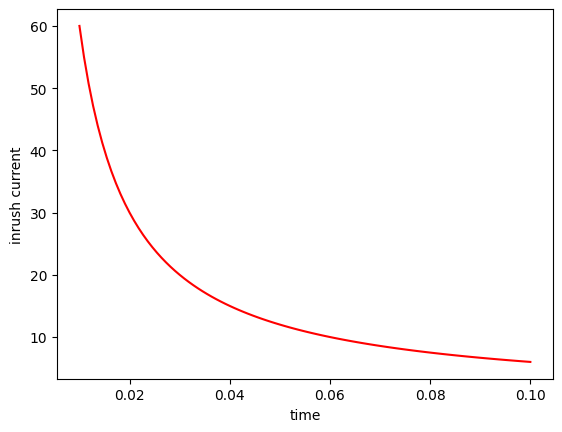

In [31]:
import numpy as np
import matplotlib.pyplot as plt
dV = 1
C = 0.6
time_arr = np.linspace(1e-2, 1e-1, 100)
I_inrush = C * dV / time_arr

### PLOTTING
fig = plt.figure()
# Create 1 3D subplot:
ax = fig.add_subplot(111)
# Create a 3D scatter plot with x,y,z orthogonal axis, and red "o" markers:
ax.plot(time_arr, I_inrush, c='red')
# Create x,y,z axis labels:
ax.set_xlabel('time')
ax.set_ylabel('inrush current')
plt.show()


Assuming the startup current is between 20 and 40 amps, the driver capacitors can deliver that for about 20 ms.

**Sources:**
> (1) https://www.pes-publications.ee.ethz.ch/uploads/tx_ethpublications/2_JWK_1999_Analytical_Calculation_RMS_00816361.pdf \
> (2) https://www.specterengineering.com/blog/2019/9/7/dc-link-capacitor-selection-for-your-inverter \
> (3) https://www.ecicaps.com/tech-tools/technical-papers/low-inductance-dc-bus-capacitor-high-power-traction-motor-drive-inverters/ \
> (4) https://koreascience.kr/article/JAKO201614735141189.pdf \
> (5) https://e2e.ti.com/support/motor-drivers-group/motor-drivers/f/motor-drivers-forum/1002829/dc-link-capacitor-for-bldc-motor-drive-suggestion

**_NOTE :_** 
* Check the simulations of single_fet_driver.asc

In order to insert a model file for a model type, add:
_"SYMATTR ModelFile Z:\home\<user_name>\<path_to_spice_library>_" right below the SYMMATRX Value <component_name>.asy symbol-file

## Examples

### TIDA-00472

The DC bus capacitor here is mainly used for regenerative breaking power storage, ripple current and to prevent power supply instabilities from propagating into the motor.
The capacitor values of about 214 uF was calculated using the following steps:

In [32]:
import math
# GRID
Vphase = 230 # Grid phase voltage
Vampl = 230 * math.sqrt(2)
f_grid = 50 # Grid frequency
# MOTOR
P_DC = 250 # Watt: Motor rated power
dV = 0.1 # Maximum voltage ripple in %
V_DC_AVG = Vphase*math.sqrt(2)*(1-dV/2) # Average DC voltage assumed given linear fluctuation around the ripple

In [39]:
### CALCULATE THE ACTUAL MIN AND MAX VOLTAGE RANGE
Vmax = Vampl
Vmin = Vmax*0.9
print(f"[Vmin, Vmax] ({Vmin} -> {Vmax})")

[Vmin, Vmax] (292.7422074112307 -> 325.2691193458119)


In [34]:
# Calculate the time the capacitor is not being charged by the grid (so from 0 -> theta
# Vphase*sqrt(2)*sin(theta) = Vmin
theta = math.asin(Vmin/Vmax)

In [35]:
### Add pi/2 to get the full angle the input voltage is below the required voltage.
### This seems to be an underestimation, since the full bridge does conduct for angles between -1.198 and -pi/2
theta_discharge = theta + math.pi/2
### Calculate the time of discharge
t_discharge = theta_discharge / (2*math.pi*f_grid)

In [36]:
### Rated input current
I_DC = P_DC / (dV*Vampl)

In [37]:
C_min = I_DC*t_discharge / V_DC_AVG
print(f"The minimum capacitance must be greater than {C_min*1e6} uF")

The minimum capacitance must be greater than 213.02201444415817 uF


**NOTE:** This calculation above is simply a calculation for the single-phase ac-dc power converter, it does not take into account any transient power consumption of the bldc motor. A calculation of this sort does not seem to be necessary in this case.

**Sources:**
> https://www.ti.com/tool/TIDA-00472 \
> https://www.ti.com/lit/ug/tiduar7a/tiduar7a.pdf?ts=1719268683807&ref_url=https%253A%252F%252Fwww.ti.com%252Fsitesearch%252Fen-us%252Fdocs%252Funiversalsearch.tsp%253FlangPref%253Den-US

## 